## Topic Modeling - Framework

This Notebook allows for topic tagging from the words found in the responses. The client had certain themes that fell under different values the company emphasizes. They wanted to associate responses from their employees to these themes. I interviewed the users and found which words or phrases they associated with each theme. This dictionary of words and themes was stored in an excel file to allow the client to easily manipulate and customize the dictionary.I included a screenshot of the excel as an  example:


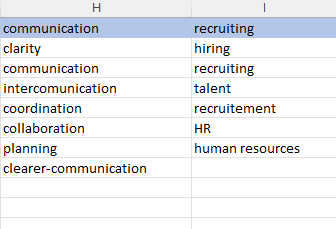

We can see that for the two themes of **Communication** and **Recruiting** that they have associated words with them. The following notebook shows code that will convert from raw data, normalize the text and preparing it for analysis, then tagging each response with the topic. Some resources will contain multiple tags. This will allow the client to see how many responses in both a positive and negative sentiment associated with a theme of theirs. They can then evaluate their responses quantitatively. 

In [1]:
# importing libraries
import pandas as pd
import spacy
import string
import re
import numpy as np
from collections import defaultdict

The following cells are all the functions that will be used throughout the script

In [7]:
# standardize and normalize text
def normalize(text):
    """ Helper function to normalize text"""
    # convert to lower
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove numbers
    # To do??
    
    # remove hyphens
    text = ''.join(text.split('-'))
    
    # Remove multiple white spaces 
    re.sub("\s\s+", " ", text)
    
    # load english model to tokenize text and stop words
    nlp = spacy.load('en_core_web_sm')
    stops = spacy.lang.en.stop_words.STOP_WORDS 
    
    # convert to tokens 
    text = nlp(text)
    
    # Lemmatize and Remove standard stop words
    text = " ".join([token.lemma_ for token in text if not token.is_stop])
    return text

In [104]:
def load_survey_response_text(survey_filepath: str, feedback_type: str):
    """ Helper function to load survey responses (only one type)"""
    
    if feedback_type.lower() in ['pos', 'positive', 'good']:
        columns = ['ID', 'positive']
    elif feedback_type.lower() in ['neg', 'negative', 'bad']:
        columns = ['ID', 'negative']
    else:
        raise ValueError('feedback type must be specified as `good` or `bad`')
    
    df = pd.read_csv(survey_filepath, usecols = ['ID',
                                                   'What do you think the _ strengths are? (up to 5 attributes in English)',
                                                   'What do you think the _ improvement areas are? (up to 5 attributes in English)'])

    df.columns = ['ID', 'positive', 'negative']
    df = df.dropna(subset=['positive', 'negative'])
    df = df[columns]
    # output will always have two columns
    df.columns = ['ID', 'response']
    df.set_index('ID', inplace = True)
    
    # preparing data -- ryan
    # changing important words less than 3 char 
    df = df.replace('HR', "Human Resources")
    
    # replacing 3 char and less with NA
    df['response'] = np.where((df.response.str.len() <=3), 'No Answer', df.response)
    
    return df

In [105]:
def normalize_mapping(mapping):
    """ function to create a new mapping whose synonyms have been normlized consistently with the surveys"""
    lem_map = dict()
    for topic, synonyms in mapping.items():
        lem_map[topic] = []
        for syn in synonyms:
            lem_map[topic].append(normalize(syn))
    return lem_map


def find_topics_in_text(survey_comments: pd.Series, mapping: dict, feedback_type='Positive'):
    """ Function that puts the pieces together """
    results = []
    for topic, syn_list in mapping.items(): 
        for survey_id, comment in survey_comments.items():
            for syn in syn_list:
                pattern = re.compile(syn)
                if pattern.search(comment):
                    results.append({'ID':survey_id, 'Topic Name': topic, 'Feedback': feedback_type,'comment': comment, 'match_word': syn})
                    break
                    
    return pd.DataFrame(results)
        

Creating the topic dictionary from the survey csv file. 

In [106]:
# reading csv
csv = pd.read_csv(r'topic_dictionary.csv')

In [107]:
# converting csv to dictionary 
d = csv.to_dict()

In [109]:
# creating map object
mapper = defaultdict(list)

for k, v in d.items():
    for kk, vv in v.items():
        if vv is not np.nan:
            mapper[k].append(vv)
mapping = dict(mapper)

Now with the mapping object stored we can use it with the functions created above to convert our responses to topic tags. Notice that we have to adjust the feedback_type for both the first object called when we load the survey response and also when we use the find_topics_in_text function as well. These need to coincide to have an accurate dataframe. 

In [124]:
# Put it all together
df = load_survey_response_text(r'RawData.csv', 
                               feedback_type='pos')
df['response_normed'] = df['response'].apply(normalize) # new column of normalized text
norm_map = normalize_mapping(mapping)
output = find_topics_in_text(df['response_normed'], norm_map, feedback_type='Positive')

(4034, 3)
(3895, 3)


The above script created an object called **output** that will contain both the dataframes with the number of responses found which contained a theme based off the topic dictionary. For the positive sentiment there were 4,034 responses with a theme mentioned and 3,895 responses with negative sentiment for a theme. 

Now you can call the below statement to output it as a CSV to analyze further or pull it into a Business Intelligence tool that is easier for less technical users. 

In [128]:

output.to_csv('output.csv')

The below is an example of the dataframe produced from the above script. It creates this dataframe with the Topic Name, the sentiment, the response and the word which was found in the response that created the mapping of this Topic. For the first row we see that for response ID 6 they had a positive response to the theme of *Team*. 

In [142]:
saved_positive_df

,ID,Topic Name,Feedback,comment,match_word
0,6,Team,Positive,1 extremely committed and hard work team membe...,team
1,15,Team,Positive,bold inclusive teamwork empower visionary,team
2,20,Team,Positive,infotainment audio team collaboration across g...,team
3,23,Team,Positive,workplace culture collaboration team work stra...,team
4,39,Team,Positive,knowledge innovation teamwork,team
...,...,...,...,...,...
5959,3974,Outer Team,Positive,supportive team supportive management freedom ...,cross functional
5960,3991,Outer Team,Positive,have domain expert cross functional team,cross functional
5961,4029,Outer Team,Positive,crossfunctional teamwork,crossfunctional
5962,4033,Outer Team,Positive,great team work great assistance to support...,cross functional


In [143]:
saved_negative_df

,ID,Topic Name,Feedback,comment,match_word
0,10,Team,Negative,help team across sbus be really need recognize...,team
1,17,Team,Negative,1 lack of leadership unclear direction unc...,team
2,23,Team,Negative,need more team recognition more hardware procu...,team
3,31,Team,Negative,the project team be now too fractured everyone...,team
4,33,Team,Negative,coordination between test and dev team about h...,team
...,...,...,...,...,...
6193,3960,Outer Team,Negative,1 focus on multi discipline handson base train...,crossfunctional
6194,4033,Outer Team,Negative,I think there be need to plan more training be...,cross functional
6195,3017,Inner Team,Negative,efficiency use of modern application interteam...,interteamwork
6196,3236,Inner Team,Negative,process rasic knowledge sharing work duplicati...,intersbu
